In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

def RF_complete(data_t: "df", data_s_list: "list(df)", feature_t, n_tree=50, n_feature=5, f_sample=0.3, n_best_tree=5):
    '''
    TODO:
    - data_s_list might be a list of dataframes... Not just a list corresponding to one thing
    '''
    K = len(data_s_list) # Number of datasets given for training
    print(f"{K} additional datasets used for prediction.")

    if feature_t not in data_t.columns:
        print("Feature-of-interest not found in data_t! Please check column names of input data.")
        return None
    else:
        print("Feature-of-interest located!")

    mu = []
    sigma = []

    for k in range(0, K): # Iteratingg over data_s_list
        data_assist = data_s_list[k] #.iloc[k-1] # Indexing is in terms of rows
        # Locate feature of interest in training dataset k of K
        if feature_t in data_assist.columns:
            f_t_ind = list(data_assist.columns).index(feature_t) # Finds col/index of current sera that matches virus of interest
        else:
            print(f"feature_t not found in assisting data {k}!")
            continue
        # Check for feature match
#         if not data_t.columns.equals(data_assist.columns): # MISTAKE!!! -> Solved?
        if sum(data_t.columns != data_assist.columns) > 0: # Check for any non overlapping viruses between training dataset and prediction data
            print(f"Features not matched for assisting data {k}! Skipped to next data.")
            continue
        # Transferability function
        trans_true_err = []
        trans_pred_err = []
        print(f"data_assist shape: {data_assist.shape}")
        print(f"Iterating over {data_assist.shape[1]}")
        # Iterate over dataset columns
        for j in range(0, data_assist.shape[1]): # Iterate over rows of training data
            feature_trans = data_assist.columns[j]
#             if not data_t.iloc[:, j].isna().sum() > 0: # Check this for mistake
            if data_t.iloc[:, j].notna().sum() > 0:
                rf_1t1 = RF_complete_1t1(data_assist, data_t, feature_t=feature_trans, n_tree=n_tree,
                                         n_feature=n_feature, f_sample=f_sample, k=k)

                if rf_1t1 is not None: # Check to see that rf_1t1 is a val and not None or a bool
                    trans_true_err.extend(rf_1t1["true_err"])
                    trans_pred_err.extend(rf_1t1["pred_err"])

        if len(trans_true_err) == 0:
            continue
        else: # ooh tough cookie
            print("Doing lm stuff")
            lm_coeff = np.polyfit(trans_pred_err, trans_true_err, 1)
            a = lm_coeff[0]
            b = lm_coeff[1]
            c = np.sqrt(np.mean((a * np.array(trans_pred_err) + b - np.array(trans_true_err)) ** 2))

            def f_transfer(x, a, b, c):
                return max(x, a * x + b + c)

            print([f"a={round(a, 3)}", f"b={round(b, 3)}", f"c={round(c, 3)}"])

            rf_1t1 = RF_complete_1t1(data_assist, data_t, feature_t=feature_t, n_best_tree=n_best_tree, n_tree=n_tree,
                                     n_feature=n_feature, f_sample=f_sample, k=k)
            print(f"rf_1t1: {rf_1t1}")
            mu.append(rf_1t1["mu"])
            sigma.append(f_transfer(np.mean(rf_1t1["pred_err"]), a, b, c))
    print("mu", mu) # Somethings up with computation of mu
    print("sigma", sigma)
    A = 0
    B = 0
    tt = 0
    print(f"len sigma: {len(sigma)}")
    print(sigma)
    print(f"K: {K}")
    for k in range(K):
        print(f"k: {k}")
        if sigma[k] is not None:
            tt += 1
            A += mu[k] / sigma[k] ** 2
            B += 1 / sigma[k] ** 2

    print(f"{tt} assisting data used for prediction.")
    return {"predictions": A / B, "errors": 1 / np.sqrt(B)}

def RF_complete_1t1(data_assist, data_t, feature_t, n_tree=50, n_feature=5, f_sample=0.3, n_best_tree=5, k=1):
    if feature_t in data_assist.columns:
#         f_t_ind = data_assist.index.get_loc(feature_t)
        f_t_ind = list(data_assist.columns).index(feature_t)
    else:
        print(f"feature_t not found in assisting data {k}!")
        return None
    # IM WORKING ON THIS ... REFERS TO VIRUSES I THINK, NOT SERA. Yeah R code mentions finding feasible features
#     if (data_assist.apply(lambda x: x.count(), axis=0) / data_assist.shape[0] > 0.8).sum() > n_feature:
#         f_ind = data_assist.index[
#             (data_assist.apply(lambda x: x.count(), axis=0) / data_assist.shape[0] > 0.8)].tolist()
    if (data_assist.apply(lambda x: x.count(), axis=0) / data_assist.shape[0] > 0.8).sum() > n_feature:
        # f_ind should be a list of columns/viruses
        f_ind = list(data_assist.columns[(data_assist.apply(lambda x: x.count(), axis=0) / data_assist.shape[0] > 0.8).tolist()]) # Only consider viruses that are covered by > 80% of sera in study
        if feature_t in f_ind:
            f_ind.remove(feature_t)
    else:
        print(f"n_feature too large for assisting data {k}! Skipped to next data.")
        return None
    # Left off here
    f_tmp_ind = [data_t.columns.get_loc(f) for f in f_ind if f in data_t.columns]
    f_feasible = [f for f in data_t.columns[f_tmp_ind] if data_t[f].count() > 2]
    f_ind = [i for i in f_ind if i in f_feasible]
    f_ind = [f_ind[idx] for idx in range(len(f_ind)) if f_ind[idx] == f_feasible[idx]] # Added cuz the r code has this after f.feasible asgn
    if len(f_feasible) < 2:
        print(f"n_feature too large for assisting data {k}! Skipped to next data.")
        return None

    data_assist = data_assist.dropna(subset=[feature_t])
    print("feature_t check 0", feature_t)
    RMSE = []
    f_sel_ind = []
    tree = []
#     print("feature_t check 1", feature_t)
    for i in range(n_tree):
        f_sel_ind.append(np.random.choice(f_ind, n_feature, replace=True))
        sample_sel = np.random.choice(data_assist.shape[0], int(data_assist.shape[0] * f_sample), replace=True)
        # LAST ERROR: Indexing like this might be better:
        # data_assist.iloc[sample_sel][np.append(f_sel_ind[i],feature_t)]
        # We want to include the column of f_t_ind into our data_train
#         data_train = data_assist.iloc[sample_sel, f_sel_ind[i] + [f_t_ind]]
        data_train = data_assist.iloc[sample_sel][np.append(f_sel_ind[i],feature_t)]
#         print("feature_t check 2", feature_t)
        colm_t = data_train.apply(lambda x: x.mean(), axis=1)
        data_train = data_train - np.outer(np.ones(data_train.shape[1]), colm_t).T
        data_train.columns = np.append(f_sel_ind[i], "target")
        ###get decision tree and RMSE
        # import xgboost as xgb
        # Fit the model to the data (handles missing values)
        # tree.append(xgb.XGBRegressor(max_depth=5, min_child_weight=5))
        # tree[i].fit(data_train.iloc[:, :-1], data_train["target"]) # Sometimes runs into nan somehow... ACTUALLY just for the outdated version of sklearn, new is fine
        tree.append(DecisionTreeRegressor(min_samples_split=5))
        tree[i].fit(data_train.iloc[:, :-1], data_train["target"])
        # Compile testing dataset
        data_test = data_assist.drop([data_assist.index[idx] for idx in sample_sel], axis=0)[np.append(f_sel_ind[i], feature_t)]
        colm_t = data_test.apply(lambda x: x.mean(), axis=1)
        data_test = data_test - np.outer(np.ones(data_test.shape[1]), colm_t).T

        pred_t = tree[i].predict(data_test.iloc[:, :-1])
        RMSE.append(np.sqrt(np.mean((pred_t - data_test[feature_t]) ** 2)))
#         print("feature_t check 3", feature_t)
        
    ###predict in the target dataset
    pred_list = np.zeros((data_t.shape[0], n_best_tree))
#     print("RMSE", RMSE)
#     print("argsort", np.argsort(RMSE))
    for i in range(n_best_tree):
        j = np.argsort(RMSE)
#         f_t_ind = data_t.columns.get_loc(feature_t)
#         print("f_sel_ind",f_sel_ind)
#         print("f_sel_ind[j[i]]]", f_sel_ind[j[i]])
        f_t_sel_ind = f_sel_ind[j[i]]
#         f_t_sel_ind = [data_t.columns.get_loc(f) for f in f_sel_ind[j[i]]]
#         print("f_t_sel_ind", f_t_sel_ind)
#         print("f_t_ind", f_t_ind, "feature_t", feature_t)
#         data_test = data_t.iloc[:, np.append(f_t_sel_ind, feature_t)]
        data_test = data_t[np.append(f_t_sel_ind, feature_t)]
#         data_test = data_t.iloc[:, np.append(f_t_sel_ind, f_t_ind)]
#         data_test = data_t.iloc[:, f_t_sel_ind + [f_t_ind]]
        colm_t = data_test.apply(lambda x: x.mean(), axis=1)
#         print("ones shape", np.ones(data_test.shape[1]).shape)
#         print("colm_t shape", colm_t)
#         print("feature_t", feature_t)
#         print("selected cols", np.append(f_t_sel_ind, feature_t))
#         print("data_test", data_test)
#         print("np.outer(np.ones(data_test.shape[1]), colm_t).T", np.outer(np.ones(data_test.shape[1]), colm_t).T)
        data_test = data_test - np.outer(np.ones(data_test.shape[1]), colm_t).T
#         print("data_test", data_test)
        data_test.columns = np.append(data_test.columns[:-1], "target")
#         print("new columns", data_test.columns)
#         data_test.columns = f_sel_ind[j[i]] + ["target"] # hmmm...
#         print("j", j)
#         print('j[i]', i, j[i])
#         print(list(data_test.columns))
#         print(data_test)
        pred_t = tree[j[i]].predict(data_test.iloc[:, :-1])
#         print("pred_t",pred_t)
        pred_t[np.where(data_test.iloc[:, :-1].isna().sum(axis=1) > 0)] = np.nan
        pred_list[:,i]=pred_t


    # Obtain predictions and errors
#     print(pred_list.shape)
    true_err = np.sqrt(np.nanmean((pred_list - data_test['target'].values.reshape(-1, 1))**2, axis=0)) # Changed from axis  1 to 0 for taking mean :-/
#     print(true_err)
    argSortedRMSE = [RMSE[idx] for idx in np.argsort(RMSE)]
    pred_err = argSortedRMSE[:n_best_tree]
#     print(n_best_tree, type(n_best_tree))
#     print('np.ones(1, n_best_tree) shape', np.ones((1, n_best_tree)).shape)
#     print('colm_t shape', colm_t.shape)
    pred_list = pred_list + np.outer(np.ones((1, n_best_tree)), colm_t).T
#     pred_list = pred_list + t(rep(1, n_best_tree) %*% t(colm.t))
    mu = np.nanmean(pred_list, axis=1)
    return {'mu': mu, 'true_err': true_err, 'pred_err': pred_err}


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

In [3]:
def non_trivialize_df(df):
    # Search columns for trivial feature (virus)
    dropped = 0
    for idx, col in enumerate(df.columns):
        uniques = df[col].unique()
        num_unique = len(uniques)
        if num_unique == 1 and 'sera_table' not in col and "*" in uniques: # Critereon for a missing virus
#             print(idx, col, num_unique, uniques)
            df = df.drop(columns=col)
            dropped += 1 # Count dropped virus
    # Search rows for trivial entry (serum)
    for idx in list(df.index):
        num_unique = len(df.loc[idx].unique())
        if num_unique == 3: # Serum name and table name are 2 constant features.
#             print(idx, num_unique)
            df = df.drop(index=idx)
    df = df.replace("*", np.nan)
    df = df.set_index('Measurements (Sera in Rows/Viruses in Columns)')
    df = df.drop(['sera_table'], axis=1)
    df = df.applymap(lambda x: pd.to_numeric(x, errors='coerce') ) # Might wanna just do df.map
    # Return data and number of dropped viruses
    return df, dropped


def plot_heatmap(df):
    mask = df.isnull()
    g = sns.heatmap(df, cmap='gray',mask=mask)
    g.set_facecolor('xkcd:salmon')
    return g


def plot_heatmap_subplot(table_dict):
#     keys = sorted(list(table_dict.keys()))
    keys = ["TableS1", "TableS3", "TableS5", "TableS6", "TableS13", "TableS14"]
    N = len(keys)
    fig, axs = plt.subplots(nrows=1, ncols=N, figsize=(30, 5))
    for idx, key in enumerate(keys):
        df, dropped_viruses = table_dict[key]
        percent_missing = sum(list(df.isna().sum())) / (df.shape[0] * df.shape[1]) # Proportion of missing vals in table
        df = np.log10(df)
        sera_num = df.shape[0]
        virus_num = df.shape[1]
        mask = df.isnull()
        g = sns.heatmap(df,
                        xticklabels=False,
                        yticklabels=False,
                        cmap='gray',
                        mask=mask,
                        ax=axs[idx])
        g.set_facecolor('xkcd:salmon')
        axs[idx].set_xlabel(f'{sera_num} Sera x {virus_num} Viruses\n{percent_missing * 100:.2f}% Missing')
        axs[idx].set_title(key)
    return fig, axs

In [4]:
'''
data_t: DF of sera (table specific) X Viruses (No viruses dropped yet) to make prediction on
data_s_list: list of columns of data table for virus to train on ... Its the whole df I think
feature_t: A particular virus to predict (And I assume we omit this from training)
n_tree=50
n_feature=5
f_sample=0.3
n_best_tree=5
'''

flu_df = pd.read_csv("../CrossStudyCompletion/Matrix Completion in R/InfluenzaData.csv", sep=',')
sera = flu_df['Measurements (Sera in Rows/Viruses in Columns)'].tolist()
sera_tables = [i[i.index('Table'):] for i in sera]
table_keys = set(sera_tables)
flu_df['sera_table'] = sera_tables

flu_table_dict = {table_key: flu_df.loc[flu_df['sera_table']==table_key] for table_key in table_keys}
filtered_flu_table_dict = {key: non_trivialize_df(arg) for key, arg in list(flu_table_dict.items())}

predict_table = 'TableS14'
train_table = 'TableS13'
data_df = flu_df.set_index("Measurements (Sera in Rows/Viruses in Columns)")
data_df = data_df.applymap(lambda x: pd.to_numeric(x, errors='coerce') )
data_df = np.log10(data_df)
data_df['sera_table'] = sera_tables

data_t = data_df.loc[data_df['sera_table']==predict_table].drop(['sera_table'], axis=1)
data_s = data_df.loc[data_df['sera_table']==train_table].drop(['sera_table'], axis=1)
data_s_list = [data_s] # [[col] for col in list(data_s.columns)]
feature_t = "A/PANAMA/2007/99"

# K = len(data_s) # 160
# data_assist = data_s
# f_t_ind = list(data_assist.columns).index(feature_t)
# data_t.columns.equals(data_t.columns)
# f_t_ind = data_assist.columns.get_loc(feature_t)
# n_tree=50
# n_feature=5
# f_sample=0.3
# n_best_tree=5
# k=1

/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28998/760941675.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: pd.to_numeric(x, errors='coerce') ) # Might wanna just do df.map
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28998/760941675.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: pd.to_numeric(x, errors='coerce') ) # Might wanna just do df.map
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28998/760941675.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: pd.to_numeric(x, errors='coerce') ) # Might wanna just do df.map
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28998/760941675.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: pd.to_numeric(x, errors='coerce')

In [5]:
results = RF_complete(data_t = data_t,
                      data_s_list=[data_s],
                      feature_t=feature_t)

1 additional datasets used for prediction.
Feature-of-interest located!
data_assist shape: (160, 81)
Iterating over 81
feature_t check 0 A/AUCKLAND/5/96
feature_t check 0 A/BRISBANE/22/94


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


feature_t check 0 A/CHRISTCHURCH/1/96
feature_t check 0 A/FUJIAN/140/2000


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


feature_t check 0 A/NEW_YORK/55/2004
feature_t check 0 A/PANAMA/2007/99


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


feature_t check 0 A/PERTH/16/2009
feature_t check 0 A/PERTH/27/2007


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


feature_t check 0 A/TASMANIA/1/97
feature_t check 0 A/VICTORIA/1/93


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


feature_t check 0 A/VICTORIA/110/2004
feature_t check 0 A/WELLINGTON/96/93


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


feature_t check 0 BI/16190/68
feature_t check 0 BI/1761/76


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


feature_t check 0 BI/2271/76
feature_t check 0 NL/233/82


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


feature_t check 0 NL/620/89
feature_t check 0 NL/823/92


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


feature_t check 0 VN016/EL135/2008
feature_t check 0 VN053/2010


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


Doing lm stuff
['a=0.796', 'b=0.128', 'c=0.057']
feature_t check 0 A/PANAMA/2007/99
rf_1t1: {'mu': array([0.68291507, 1.44927532, 0.95305366, 1.43821367, 1.27761655,
       1.59537044, 2.16047063, 1.88218513, 1.05017167, 1.50171666,
       1.74588543, 1.2859785 , 1.13044633, 0.56752024, 1.63992765,
       1.86629743, 1.97189684, 0.58106659, 2.66892463, 0.73576256,
       1.89037983, 1.65796556, 0.73308674, 1.59854797, 1.33865875,
       1.93319299, 1.87621231, 1.28366539, 2.04376613, 1.10273246,
       1.27678036, 1.37461511, 2.0970871 , 0.86620889, 1.50171666,
       1.71578243, 0.85039721, 1.24842576, 1.68850295, 0.66786357,
       2.09565362, 1.33777911, 1.40058492, 1.36959794, 2.00271658,
       1.56390998, 0.68291507, 2.36323584, 1.96011845, 1.8013892 ,
       1.90567024, 2.06525198, 0.92581761, 1.84236272, 1.33705803,
              nan, 1.92263739, 0.63776057, 0.74312107, 1.91511164,
       1.00007167, 1.33211688, 0.97849786, 2.27543542, 1.26865733,
       2.19516076, 1.47483898,

/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


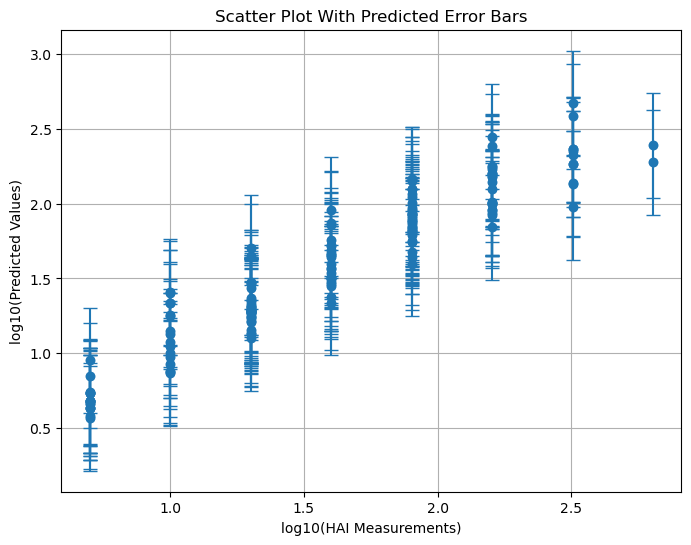

In [6]:
import matplotlib.pyplot as plt

# Assuming 'feature.t' is the feature you want to use as the x-axis
x_data = data_t[feature_t]

# 'out' contains the predictions
y_data = results['predictions']

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x_data, y_data, alpha=0.5)
plt.xlabel("log10(HAI Measurements)")
plt.ylabel("log10(Predicted Values)")
plt.title("Scatter Plot With Predicted Error Bars")
plt.grid(True)


plt.errorbar(data_t[feature_t], y_data,
             yerr=results['errors'], fmt='o', capsize=5, label="Error Bars")

# Actual prediction error (as n-folds)
# actual_error = 10 ** np.sqrt(np.mean((np.log10(y_train) - np.log10(y_pred)) ** 2))
# print("Actual Prediction Error (as n-folds):", actual_error)


plt.show()

In [35]:
tableS5.columns

Index(['A/AUCKLAND/20/2003', 'A/AUCKLAND/5/96', 'A/BANGKOK/1/97',
       'A/BEIJING/32/92', 'A/BRISBANE/10/2007', 'A/BRISBANE/22/94',
       'A/BRISBANE/22/96', 'A/BRISBANE/3/2005', 'A/BRISBANE/342/2003',
       'A/BRISBANE/5/2002', 'A/CALIFORNIA/7/2004', 'A/CANBERRA/1/96',
       'A/CANBERRA/9/97', 'A/CHRISTCHURCH/1/96', 'A/CHRISTCHURCH/68/99',
       'A/FUJIAN/140/2000', 'A/FUJIAN/411/2002', 'A/FUKUOKA/55/2002',
       'A/JOHANNESBURG/33/94', 'A/NANCHANG/933/95', 'A/NEW_YORK/55/2004',
       'A/NEWCALEDONIA/12/2004', 'A/PANAMA/2007/99', 'A/PERTH/16/2009',
       'A/PERTH/27/2007', 'A/PERTH/5/97', 'A/PERTH/9/97',
       'A/PHILIPPINES/427/2002_MDCK', 'A/PHILIPPINES/472/2002_EGG',
       'A/SHANDONG/9/93', 'A/SINGAPORE/37/2004', 'A/SOUTH_AUSTRALIA/53/2001',
       'A/SOUTH_AUSTRALIA/84/2002', 'A/SYDNEY/228/2000', 'A/SYDNEY/5/97',
       'A/TASMANIA/1/97', 'A/TOWNSVILLE/2/99', 'A/TOWNSVILLE/36/2003',
       'A/TOWNSVILLE/4/2002', 'A/URUGUAY/716/2007', 'A/VICTORIA/1/93',
       'A/VICTOR

In [97]:
train_table = filtered_flu_table_dict['TableS5'][0]
feature_t = "A/FUJIAN/140/2000"
predict_table='TableS14'
data_t = data_df.loc[data_df['sera_table']==predict_table].drop(['sera_table'], axis=1) # Data that we want to make prediction on 
selected_viruses_list = ["A/NEW_YORK/55/2004", "A/PANAMA/2007/99", "A/WELLINGTON/96/93", "BI/16190/68", "A/TASMANIA/1/97"] # Virses to use for training and predicting

n_feature = 5
n_tree=50
f_sample=0.3
n_best_tree=5
k=1

'''
When talking about cross-validation RMSE,
I train a tree on data (5 selected viruses X subset of sera) and make predictions
on testing/validating data (5 selected viruses X all viable sera that weren't used for training).
I believe that I am cross validating on Sera as selected viruses remain constant

accuracy of a tree trained on
'''

data_assist_train = np.log10(train_table) # Main dataframe used in training and validation (Perform log10 transform)
# Choose viruses that are covered by 80% of sera 
if (data_assist_train.apply(lambda x: x.count(), axis=0) / data_assist_train.shape[0] > 0.8).sum() > n_feature:
    # f_col_ind_train should be a list of viruses covered by >80% of sera
    f_col_ind_train = list(data_assist_train.columns[(data_assist_train.apply(lambda x: x.count(), axis=0) / data_assist_train.shape[0] > 0.8).tolist()]) # Only consider viruses that are covered by > 80% of sera in study
    if feature_t in f_col_ind_train:
        f_col_ind_train.remove(feature_t)
else:
    print(f"n_feature too large for assisting data {k}! Skipped to next data.")
f_tmp_ind = [data_t.columns.get_loc(col) for col in f_col_ind_train if col in data_t.columns] # Find indices of columns that intersect f_col_ind_train and data_t
f_feasible = [col for col in data_t.columns[f_tmp_ind] if data_t[col].count() > 2] # Choose viruses that have more than 2 sera values in prediction data
f_col_ind_train = [col for col in f_col_ind_train if col in f_feasible] # Intersects cols from f_feasible and f_col_ind_train
if len(f_feasible) < 2:
    print(f"n_feature too large for assisting data {k}! Skipped to next data.")

data_assist_train = data_assist_train.dropna(subset=[feature_t]) # Drops NAs in training data for target

In [98]:
# virus_col_sel = np.random.choice(f_ind, n_feature, replace=True) # Random viruses to train on
virus_col_sel = np.array(selected_viruses_list) # Viruses we specifically want to train on and use for predictions in predicting data
sera_row_sel = np.random.choice(data_assist_train.shape[0], int(data_assist_train.shape[0] * f_sample), replace=True) # Randomly selected sera
# We want to include the column of f_t_ind into our data_train
data_train = data_assist_train.iloc[sera_row_sel][np.append(virus_col_sel,feature_t)] # Training data subset covering virus_col_sel viruses and sera_row_sel sera
col_mean_t = data_train.apply(lambda x: x.mean(), axis=1) # Prepare to mean center the training data
data_train = data_train - np.outer(np.ones(data_train.shape[1]), col_mean_t).T # Mean center the training data
data_train.columns = np.append(virus_col_sel, "target")

dtr = DecisionTreeRegressor(min_samples_split=5)
dtr.fit(data_train.iloc[:, :-1], data_train["target"]) # Train on selected viruses and sera, test with target virus

# Compile testing dataset, really performing cross validation
data_test = data_assist_train.drop([data_assist_train.index[idx] for idx in sera_row_sel], axis=0)[np.append(virus_col_sel, feature_t)] # Testing data subset covering virus_col_sel viruses and all sera not covered by training data 
col_mean_t = data_test.apply(lambda x: x.mean(), axis=1)
data_test = data_test - np.outer(np.ones(data_test.shape[1]), col_mean_t).T
pred_t = dtr.predict(data_test.iloc[:, :-1]) # Make prediction on target using unforeseen data
RMSE = np.sqrt(np.mean((pred_t - data_test[feature_t]) ** 2))




In [5]:
def between_table_trees(target_table: "pd.DataFrame",
                        source_tables: "list(pd.DataFrame)",
                        feature_t: "str",
                        selected_viruses_list: "list(str)" = ["A/NEW_YORK/55/2004", "A/PANAMA/2007/99", "A/WELLINGTON/96/93", "BI/16190/68", "A/TASMANIA/1/97"],
                        n_feature = 5,
                        n_tree=50,
                        f_sample=0.3,
                        n_best_tree=5,
                        k=1):
    '''
    Each source table is used for training a tree and finding its
    associated cross-validation RMSE. Table which you want to make
    predictions on is also required so that trees can be trained 
    with relevant viruses.
    
    - target_table should be a dataframe where columns are viruses
      and row indices are seras. The value for each virus-serum pair
      is an HAI score for binding.
    - tables source_tables are analagous to target_table in structure
    
    Do yourself:
    - Evaluate tree using target_table data (data_t) that possesses
      selected viruses
      
    When talking about cross-validation RMSE,
    I train a tree on data (5 selected viruses X subset of sera) and make predictions
    on testing/validating data (5 selected viruses X all viable sera that weren't used for training).
    I believe that I am cross validating on Sera as selected viruses remain constant

    accuracy of a tree trained on
    '''
#     np.random.seed(42) # Random seed selection
    tree_dict = dict() # Will contain trained tree, cross-validation RMSE, and (truth, predictions) for cross validation 
    for idx, train_table in enumerate(source_tables):
        
        # Feature selection step
        
        data_t = target_table # Data that we want to make prediction on 
        data_assist_train = train_table #np.log10(train_table) # Main dataframe used in training and validation (Perform log10 transform)
        # Choose viruses that are covered by 80% of sera 
        if (data_assist_train.apply(lambda x: x.count(), axis=0) / data_assist_train.shape[0] > 0.8).sum() > n_feature:
            # f_col_ind_train should be a list of viruses covered by >80% of sera
            f_col_ind_train = list(data_assist_train.columns[(data_assist_train.apply(lambda x: x.count(), axis=0) / data_assist_train.shape[0] > 0.8).tolist()]) # Only consider viruses that are covered by > 80% of sera in study
            if feature_t in f_col_ind_train:
                f_col_ind_train.remove(feature_t)
        else:
            print(f"n_feature too large for assisting data {k}! Skipped to next data.")
        f_tmp_ind = [data_t.columns.get_loc(col) for col in f_col_ind_train if col in data_t.columns] # Find indices of columns that intersect f_col_ind_train and data_t
        f_feasible = [col for col in data_t.columns[f_tmp_ind] if data_t[col].count() > 2] # Choose viruses that have more than 2 sera values in prediction data
        f_col_ind_train = [col for col in f_col_ind_train if col in f_feasible] # Intersects cols from f_feasible and f_col_ind_train
        if len(f_feasible) < 2:
            print(f"n_feature too large for assisting data {k}! Skipped to next data.")
        data_assist_train = data_assist_train.dropna(subset=[feature_t]) # Drops NAs in training data for target
        
        # Training step (and single cross validation):
        
        # virus_col_sel = np.random.choice(f_ind, n_feature, replace=True) # Random viruses to train on
        virus_col_sel = np.array(selected_viruses_list) # Viruses we specifically want to train on and use for predictions in predicting data
        sera_row_sel = np.random.choice(data_assist_train.shape[0], int(data_assist_train.shape[0] * f_sample), replace=True) # Randomly selected sera
        # We want to include the column of f_t_ind into our data_train
        data_train = data_assist_train.iloc[sera_row_sel][np.append(virus_col_sel,feature_t)] # Training data subset covering virus_col_sel viruses and sera_row_sel sera
        col_mean_t = data_train.apply(lambda x: x.mean(), axis=1) # Prepare to mean center the training data
        data_train = data_train - np.outer(np.ones(data_train.shape[1]), col_mean_t).T # Mean center the training data
        data_train.columns = np.append(virus_col_sel, "target")

        dtr = DecisionTreeRegressor(min_samples_split=5)
        dtr.fit(data_train.iloc[:, :-1], data_train["target"]) # Train on selected viruses and sera, evaluate with target virus

        # Compile testing dataset, really performing a single cross validation on data
        data_test = data_assist_train.drop([data_assist_train.index[idx] for idx in sera_row_sel], axis=0)[np.append(virus_col_sel, feature_t)] # Testing data subset covering virus_col_sel viruses and all sera not covered by training data 
        col_mean_t = data_test.apply(lambda x: x.mean(), axis=1)
        data_test = data_test - np.outer(np.ones(data_test.shape[1]), col_mean_t).T
        pred_t = dtr.predict(data_test.iloc[:, :-1]) # Make prediction on target using unforeseen data
        RMSE = np.sqrt(np.mean((pred_t - data_test[feature_t]) ** 2))
        
        # Compile real testing dataset using data_t for cross-table RMSC
        # virus_col_sel = np.random.choice(f_ind, n_feature, replace=True) # Random viruses to train on
        cross_virus_col_sel = np.array(selected_viruses_list) # Viruses we specifically want to train on and use for predictions in predicting data
        cross_sera_row_sel = np.random.choice(data_t.shape[0], int(data_t.shape[0] * f_sample), replace=True) # Randomly selected sera        data_test = data_assist_train.drop([data_assist_train.index[idx] for idx in sera_row_sel], axis=0)[np.append(virus_col_sel, feature_t)] # Testing data subset covering virus_col_sel viruses and all sera not covered by training data 
        cross_data_test = data_t.drop([data_t.index[idx] for idx in cross_sera_row_sel], axis=0)[np.append(cross_virus_col_sel, feature_t)] # Testing data subset covering virus_col_sel viruses and all sera not covered by training data 
        cross_col_mean_t = cross_data_test.apply(lambda x: x.mean(), axis=1)
        cross_data_test = cross_data_test - np.outer(np.ones(cross_data_test.shape[1]), cross_col_mean_t).T
        cross_pred_t = dtr.predict(cross_data_test.iloc[:, :-1]) # Make prediction on target using unforeseen data
        cross_RMSE = np.sqrt(np.mean((cross_pred_t - cross_data_test[feature_t]) ** 2))
        
        tree_name = f'tree_{idx}'
        tree_dict[tree_name] = [dtr, RMSE, cross_RMSE, (data_test.iloc[:, :-1], pred_t)]
    return tree_dict
    

In [6]:
'''
Draw up a boxplot for each tree, covering the RMSEs recorded
by running many times
'''
names = ['S1_S14', 'S3_S14', 'S5_S14', 'S13_S14']
intra_RMSE = {key:[] for key in names}
cross_RMSE = {key:[] for key in names}

tableS3  = data_df.loc[data_df['sera_table']=="TableS3"].drop(['sera_table'], axis=1)
tableS5  = data_df.loc[data_df['sera_table']=="TableS5"].drop(['sera_table'], axis=1)
tableS1  = data_df.loc[data_df['sera_table']=="TableS1"].drop(['sera_table'], axis=1)
tableS13 = data_df.loc[data_df['sera_table']=="TableS13"].drop(['sera_table'], axis=1)
tableS14 = data_df.loc[data_df['sera_table']=="TableS14"].drop(['sera_table'], axis=1)
for i in range(20):
    trees_targeting_S14 = between_table_trees(
                                             target_table=tableS14,
                                             source_tables=[tableS1, tableS3, tableS5, tableS13],
                                             feature_t="A/FUJIAN/140/2000",
                                             )
    
    S1_to_S14_RMSE  = trees_targeting_S14['tree_0'][1]
    S3_to_S14_RMSE  = trees_targeting_S14['tree_1'][1]
    S5_to_S14_RMSE  = trees_targeting_S14['tree_2'][1]
    S13_to_S14_RMSE = trees_targeting_S14['tree_3'][1]
    intra_RMSE['S1_S14'].append(S1_to_S14_RMSE)
    intra_RMSE['S3_S14'].append(S3_to_S14_RMSE)
    intra_RMSE['S5_S14'].append(S5_to_S14_RMSE)
    intra_RMSE['S13_S14'].append(S13_to_S14_RMSE)
    
    S1_to_S14_cross_RMSE  = trees_targeting_S14['tree_0'][2]
    S3_to_S14_cross_RMSE  = trees_targeting_S14['tree_1'][2]
    S5_to_S14_cross_RMSE  = trees_targeting_S14['tree_2'][2]
    S13_to_S14_cross_RMSE = trees_targeting_S14['tree_3'][2]
    cross_RMSE['S1_S14'].append(S1_to_S14_cross_RMSE)
    cross_RMSE['S3_S14'].append(S3_to_S14_cross_RMSE)
    cross_RMSE['S5_S14'].append(S5_to_S14_cross_RMSE)
    cross_RMSE['S13_S14'].append(S13_to_S14_cross_RMSE)
    

/opt/homebrew/Caskroom/miniforge/base/envs/stats/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/stats/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/stats/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/stats/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categ

<Axes: title={'center': 'Intra-table RSMC'}, xlabel='Table', ylabel='Intra-table RSMC'>

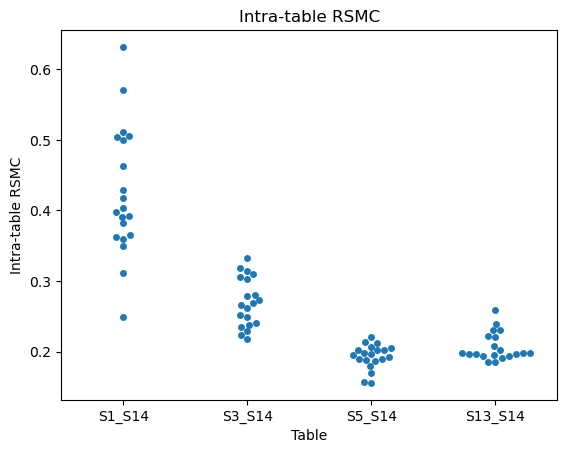

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
intra_RMSE_df = pd.DataFrame(intra_RMSE)
plt.title("Intra-table RSMC")
sns.swarmplot(x="Table", y="Intra-table RSMC", data=pd.melt(intra_RMSE_df, var_name="Table", value_name="Intra-table RSMC"))


/opt/homebrew/Caskroom/miniforge/base/envs/stats/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/stats/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/stats/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/stats/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categ

<Axes: title={'center': 'Cross-table RSMC'}, xlabel='Table', ylabel='Cross-table RSMC'>

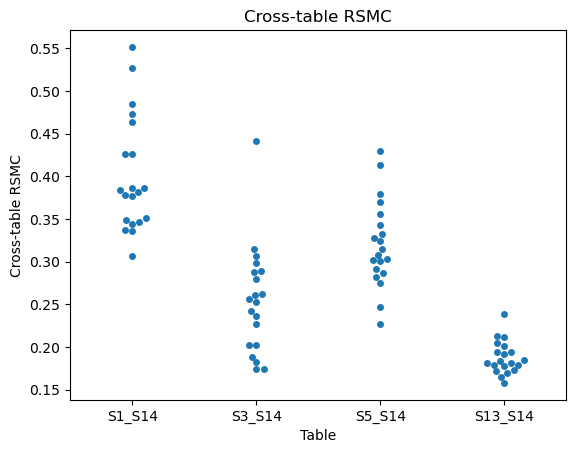

In [9]:
import seaborn as sns
cross_RMSE_df = pd.DataFrame(cross_RMSE)
plt.title("Cross-table RSMC")
sns.swarmplot(x="Table", y="Cross-table RSMC", data=pd.melt(cross_RMSE_df, var_name="Table", value_name="Cross-table RSMC"))


Text(0.5, 0.01, 'Intra Table RMSE')

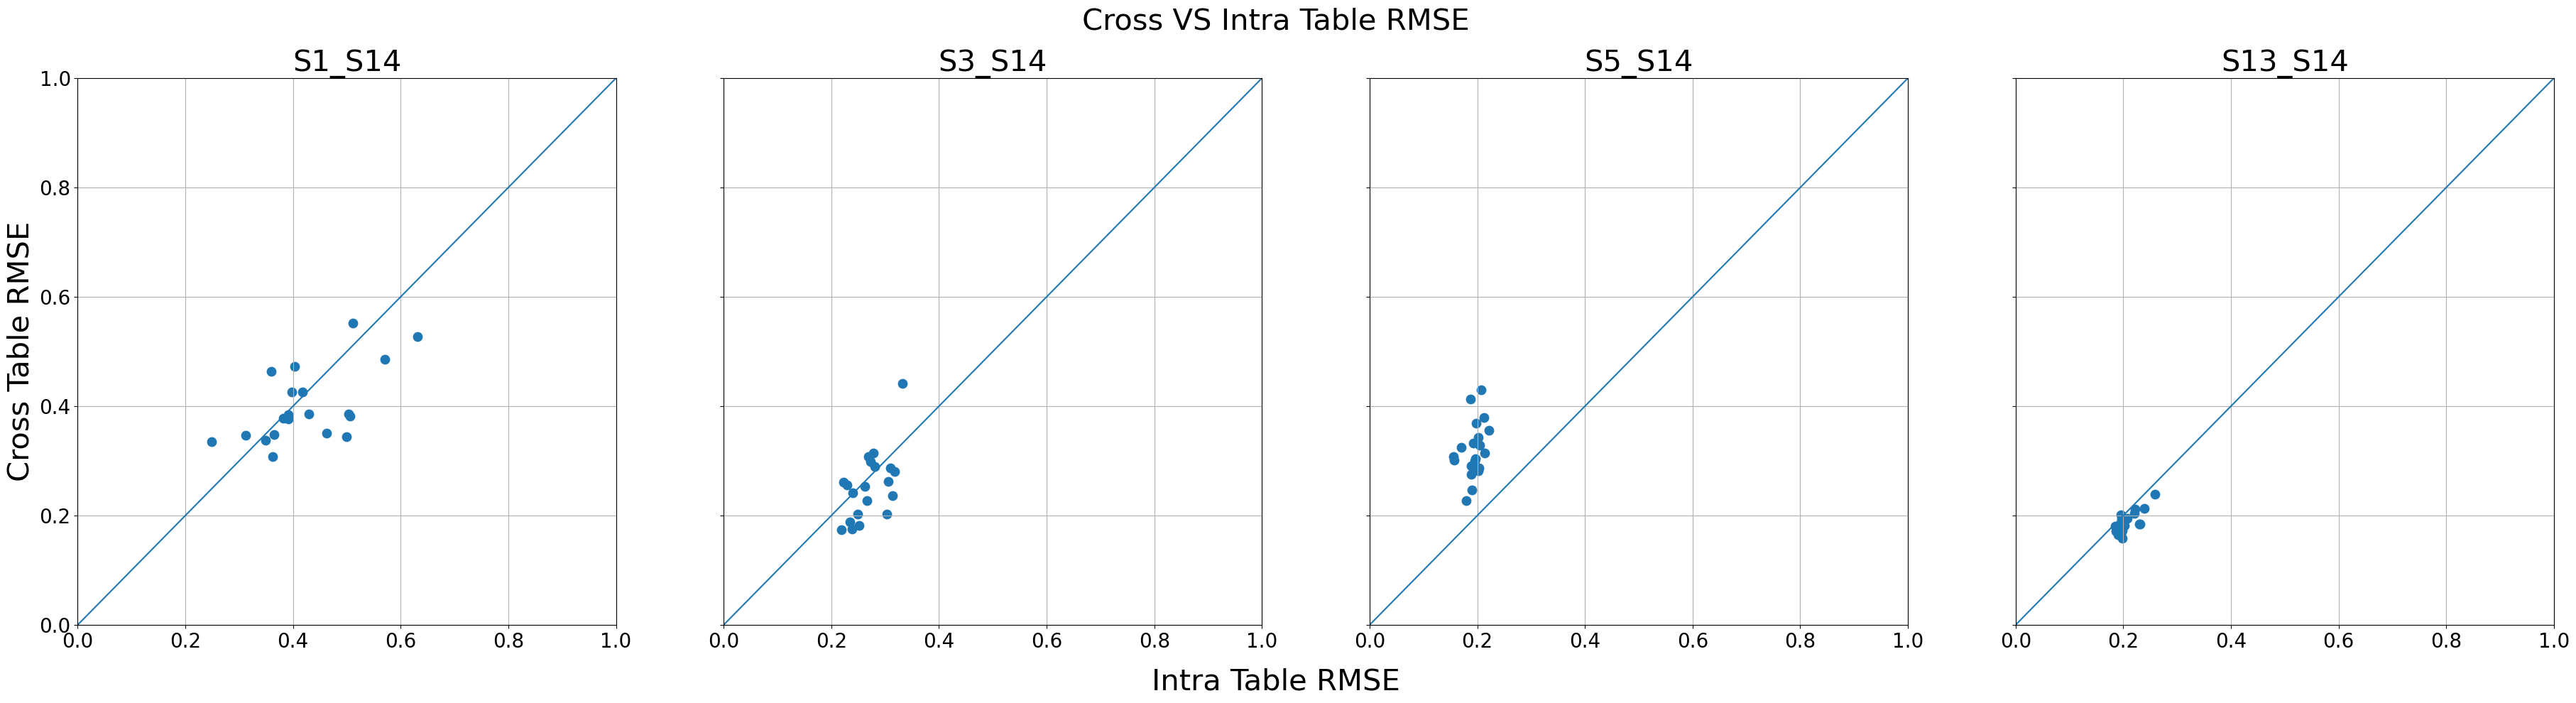

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(45,10),
                        sharex=True, sharey=True,)
for idx, name in enumerate(names):
    x = intra_RMSE_df[name]
    y = cross_RMSE_df[name]
    
    axs[idx].scatter(x,y, s=80)
    axs[idx].set_title(name, fontsize = 30)
    axs[0].set_ylabel("Cross Table RMSE", fontsize = 30)
    axs[idx].tick_params(axis='both', which='major', labelsize=20)
    axs[idx].grid()
    axs[idx].plot([0, 1], [0, 1], transform=axs[idx].transAxes)
plt.xlim([0, 1])
plt.ylim([0, 1])
fig.suptitle("Cross VS Intra Table RMSE", fontsize=30)
fig.supxlabel('Intra Table RMSE', fontsize=30)


In [68]:
S1_to_S14_RMSE  = trees_targeting_S14['tree_0'][1]
S3_to_S14_RMSE  = trees_targeting_S14['tree_1'][1]
S5_to_S14_RMSE  = trees_targeting_S14['tree_2'][1]
S13_to_S14_RMSE = trees_targeting_S14['tree_3'][1]

print(f"S1_to_S14_RMSE : {S1_to_S14_RMSE }")
print(f"S3_to_S14_RMSE : {S3_to_S14_RMSE }")
print(f"S5_to_S14_RMSE : {S5_to_S14_RMSE }")
print(f"S13_to_S14_RMSE: {S13_to_S14_RMSE}")

S1_to_S14_RMSE : 0.36690102504885624
S3_to_S14_RMSE : 0.2651258219984277
S5_to_S14_RMSE : 0.21590172196905172
S13_to_S14_RMSE: 0.2071473515596946


In [10]:
trees_targeting_S14.keys()

dict_keys(['tree_0', 'tree_1', 'tree_2', 'tree_3'])

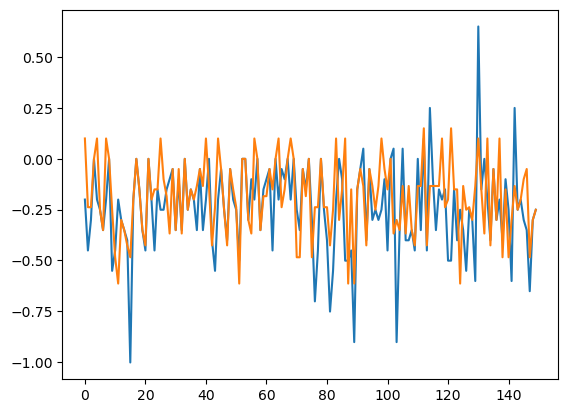

In [118]:
plt.plot(data_test[feature_t].to_numpy())
plt.plot(pred_t)

# Ensemble Model Using Multiple Training Datasets

In [82]:
'''
Predict A/FUJIAN/140/2000 between
- S5->s14
- S3->s14
- S1->s14
Using random viruses first

The train trees on Ta's virues
'''

feature_t = "A/FUJIAN/140/2000"
# Load whole data and construct feature based on table membership
flu_df = pd.read_csv("../CrossStudyCompletion/Matrix Completion in R/InfluenzaData.csv", sep=',')
sera = flu_df['Measurements (Sera in Rows/Viruses in Columns)'].tolist()
sera_tables = [i[i.index('Table'):] for i in sera]
table_keys = set(sera_tables)
flu_df['sera_table'] = sera_tables
# Construct table dict that assigns entries (vals) to their respective table groups (keys e.g. S5, S13, S14)
flu_table_dict = {table_key: flu_df.loc[flu_df['sera_table']==table_key] for table_key in table_keys}
filtered_flu_table_dict = {key: non_trivialize_df(arg) for key, arg in list(flu_table_dict.items())}
# Index and log scale data
data_df = flu_df.set_index("Measurements (Sera in Rows/Viruses in Columns)")
data_df = data_df.applymap(lambda x: pd.to_numeric(x, errors='coerce') )
data_df = np.log10(data_df)
data_df['sera_table'] = sera_tables # Assign table group to each entry in whole data

# Perform between table analyses
results_dict = dict()
predict_table = 'TableS14'
train_tables = ['TableS5', 'TableS3', 'TableS13']
for train_table in train_tables:
    data_t = data_df.loc[data_df['sera_table']==predict_table].drop(['sera_table'], axis=1)
    data_s = data_df.loc[data_df['sera_table']==train_table].drop(['sera_table'], axis=1)
    data_s_list = [data_s] # single dataframe placed in a list
    # Might wanna store tree models maybe
    results = RF_complete(data_t = data_t,
                      data_s_list=[data_s],
                      feature_t=feature_t)
    title = f'{train_table} to {predict_table}'
    results_dict[title] = results


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/760941675.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: pd.to_numeric(x, errors='coerce') ) # Might wanna just do df.map
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/760941675.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: pd.to_numeric(x, errors='coerce') ) # Might wanna just do df.map
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/760941675.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: pd.to_numeric(x, errors='coerce') ) # Might wanna just do df.map
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/760941675.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: pd.to_numeric(x, errors='coerce')

1 additional datasets used for prediction.
Feature-of-interest located!
data_assist shape: (212, 81)
Iterating over 81
feature_t check 0 A/AUCKLAND/5/96
feature_t check 0 A/BRISBANE/22/94


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


feature_t check 0 A/CHRISTCHURCH/1/96
feature_t check 0 A/FUJIAN/140/2000


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


feature_t check 0 A/NEW_YORK/55/2004
feature_t check 0 A/PANAMA/2007/99


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


feature_t check 0 A/PERTH/16/2009
feature_t check 0 A/PERTH/27/2007


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


feature_t check 0 A/TASMANIA/1/97
feature_t check 0 A/VICTORIA/1/93


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


feature_t check 0 A/VICTORIA/110/2004
feature_t check 0 A/WELLINGTON/96/93


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


feature_t check 0 BI/16190/68
feature_t check 0 BI/1761/76


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


feature_t check 0 BI/2271/76
feature_t check 0 NL/233/82


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


feature_t check 0 NL/620/89
feature_t check 0 NL/823/92


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_28500/1947818423.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


feature_t check 0 VN016/EL135/2008


ValueError: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required by DecisionTreeRegressor.

In [265]:
# Create subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30,15))
for idx, key in enumerate(list(results_dict.keys())):
    x_data = data_t
    y_data = results_dict[key]['predictions']
    axs[idx].scatter(x_data, y_data, alpha=0.5)
    axs[idx].set_xlabel("log10(HAI Measurements)")
    axs[idx].set_ylabel("log10(Predicted Values)")
    axs[idx].set_title(f"{key} Predicted Error Bars")
    axs[idx].errorbar(data_t[feature_t], y_data,
             yerr=results['errors'], fmt='o', capsize=5, label="Error Bars")
plt.grid(True)
plt.show()

{'TableS5 to TableS14': None,
 'TableS3 to TableS14': None,
 'TableS13 to TableS14': None}

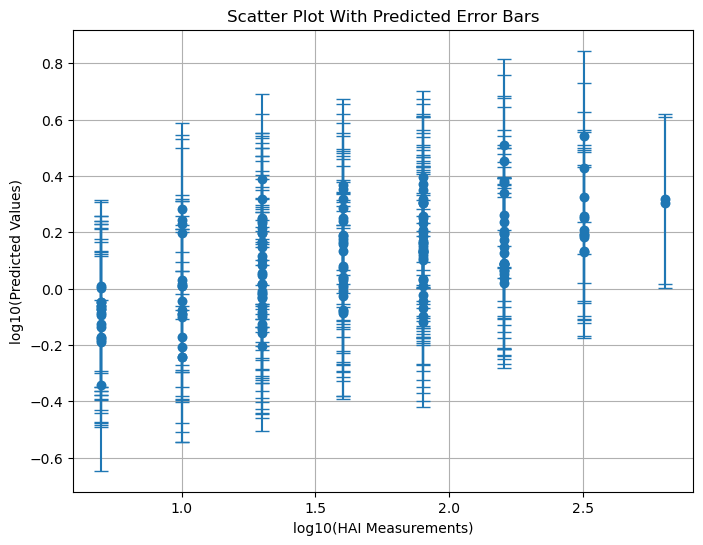

In [88]:
import matplotlib.pyplot as plt

# Assuming 'feature.t' is the feature you want to use as the x-axis
x_data = data_t[feature_t]

# 'out' contains the predictions
y_data = results['predictions']

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x_data, y_data, alpha=0.5)
plt.xlabel("log10(HAI Measurements)")
plt.ylabel("log10(Predicted Values)")
plt.title("Scatter Plot With Predicted Error Bars")
plt.grid(True)


plt.errorbar(data_t[feature_t], y_data,
             yerr=results['errors'], fmt='o', capsize=5, label="Error Bars")

# Actual prediction error (as n-folds)
# actual_error = 10 ** np.sqrt(np.mean((np.log10(y_train) - np.log10(y_pred)) ** 2))
# print("Actual Prediction Error (as n-folds):", actual_error)


plt.show()

In [43]:
data_t
predict_table

'TableS14'

In [44]:
data_df['sera_table'].unique()

array(['TableS1', 'TableS3', 'TableS5', 'TableS6', 'TableS13', 'TableS14'],
      dtype=object)

In [255]:
data_t = data_df.loc[data_df['sera_table']==predict_table].drop(['sera_table'], axis=1)
data_s_list = [
          data_df.loc[data_df['sera_table']=='TableS13'].drop(['sera_table'], axis=1),
          data_df.loc[data_df['sera_table']=='TableS6'].drop(['sera_table'], axis=1),
          data_df.loc[data_df['sera_table']=='TableS5'].drop(['sera_table'], axis=1),
         ]
feature_t = "A/PANAMA/2007/99"

In [256]:
out = RF_complete(data_t, data_s_list, feature_t)

3 additional datasets used for prediction.
Feature-of-interest located!
data_assist shape: (160, 81)
Iterating over 81
feature_t check 0 A/AUCKLAND/5/96
(160, 5)
[0.37189581 0.27945251 0.30832609 0.28013481 0.25027489]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/BRISBANE/22/94


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


(160, 5)
[0.30148824 0.3868342  0.33727764 0.32510303 0.24289709]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/CHRISTCHURCH/1/96
(160, 5)
[0.19722312 0.26959122 0.2626321  0.25164877 0.29235242]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/FUJIAN/140/2000


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


(160, 5)
[0.18290003 0.30023447 0.30468654 0.26032972 0.17083444]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/NEW_YORK/55/2004
(160, 5)
[0.2061206  0.33917918 0.36581966 0.33852705 0.26597625]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/PANAMA/2007/99


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


(160, 5)
[0.2619707  0.23342092 0.3206923  0.2826189  0.22569334]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/PERTH/16/2009
(160, 5)
[0.33642809 0.3599341  0.4251709  0.36238656 0.32599096]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/PERTH/27/2007


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


(160, 5)
[0.25717977 0.22541817 0.25063441 0.24828014 0.21323635]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/TASMANIA/1/97
(160, 5)
[0.30169577 0.23368652 0.27326249 0.32507061 0.2839393 ]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/VICTORIA/1/93


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


(160, 5)
[0.34546908 0.30528806 0.31506457 0.3443287  0.24064592]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/VICTORIA/110/2004
(160, 5)
[0.2534038  0.30085886 0.33738022 0.32686624 0.21547095]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/WELLINGTON/96/93


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


(160, 5)
[0.27675124 0.37893046 0.37327065 0.3536926  0.28720152]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 BI/16190/68
(160, 5)
[0.39673988 0.47872003 0.45074884 0.44189103 0.38328329]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 BI/1761/76


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


(160, 5)
[0.35992322 0.3384052  0.42626796 0.3532073  0.35320301]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 BI/2271/76
(160, 5)
[0.34636635 0.33113302 0.33199414 0.318432   0.39434973]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 NL/233/82


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


(160, 5)
[0.32704597 0.38728541 0.38954316 0.33709826 0.32803941]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 NL/620/89
(160, 5)
[0.29490592 0.40887652 0.41219545 0.41214168 0.30381163]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 NL/823/92


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


(160, 5)
[0.47811811 0.35435465 0.36083611 0.34116972 0.29254248]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 VN016/EL135/2008
(160, 5)
[0.27239368 0.28659479 0.27235619 0.23776353 0.22816129]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 VN053/2010


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


(160, 5)
[0.21569191 0.29239531 0.23886345 0.28676115 0.28390953]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
Doing lm stuff
['a=0.932', 'b=0.087', 'c=0.047']
feature_t check 0 A/PANAMA/2007/99
(160, 5)
[0.25601147 0.31704404 0.26877067 0.23910276 0.23334919]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
rf_1t1: {'mu': array([0.63733053, 1.27594416, 1.06522317, 1.27575119, 1.23692176,
       1.32217377, 2.10182553, 2.11631957, 1.26590983, 1.41809722,
       1.91794852, 1.18814375, 1.32217377, 0.76275969, 1.91042277,
       1.87298699, 1.85040974, 1.11145277, 2.62528325, 0.90467383,
       1.81194479, 1.63467157, 0.5971932 , 1.87967654, 1.29331128,
       1.94888771, 1.64609956, 1.07860228, 2.00574893, 0.97013591,
       1.29601283, 1.1816931 , 2.19074087, 1.25945919, 1.58096216,
       1.83767385, 1.0752575 , 0.96719545, 1.63698719, 0.7742275 ,
       1.98568027, 1.19296795, 1.16453734, 1.4657603 , 1.87298699,
       1.63698719, 0

/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


(160, 5)
[0.43411081 0.56211524 0.3188224  0.33760648 0.47089072]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/BRISBANE/22/94
(160, 5)
[0.40832719 0.51775311 0.27154641 0.46033502 0.26468908]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/CHRISTCHURCH/1/96


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


(160, 5)
[0.27322618 0.27347342 0.42534969 0.24108983 0.1895168 ]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/FUJIAN/140/2000
(160, 5)
[0.35252514 0.23328103 0.27452564 0.29140399 0.34192429]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/NEW_YORK/55/2004


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


(160, 5)
[0.42778496 0.48402493 0.62624826 0.61873781 0.69699328]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/PANAMA/2007/99
(160, 5)
[0.3969614  0.31713483 0.39899758 0.48157634 0.32197523]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/PERTH/16/2009


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


(160, 5)
[0.4022574  0.34141887 0.41919508 0.3586063  0.33925054]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/PERTH/27/2007
(160, 5)
[0.44950054 0.34593451 0.45394178 0.3375619  0.29495334]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/TASMANIA/1/97


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


(160, 5)
[0.3969937  0.41491404 0.37316382 0.49835605 0.35985425]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/VICTORIA/1/93
(160, 5)
[0.42473683 0.39217773 0.47728437 0.33729429 0.35552176]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/VICTORIA/110/2004


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


(160, 5)
[0.38154949 0.41294759 0.4741922  0.37568557 0.42971972]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 A/WELLINGTON/96/93
(160, 5)
[0.32964214 0.43884686 0.33963789 0.33826794 0.34910618]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 BI/16190/68


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


(160, 5)
[0.50881123 0.46222417 0.67320399 0.69362103 0.55646642]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 BI/1761/76
(160, 5)
[0.40097124 0.52647815 0.57488794 0.44071241 0.40279458]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 BI/2271/76


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


(160, 5)
[0.32815612 0.26483292 0.36794763 0.34838084 0.21385822]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 NL/233/82
(160, 5)
[0.48227797 0.71324811 0.46739267 0.52051891 0.43581076]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 NL/620/89


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)
/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


(160, 5)
[0.4580505  0.29666187 0.2900022  0.4276814  0.38395995]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 NL/823/92
(160, 5)
[0.40419516 0.28979301 0.35614362 0.26459558 0.42846244]
5 <class 'int'>
np.ones(1, n_best_tree) shape (1, 5)
colm_t shape (160,)
feature_t check 0 VN016/EL135/2008


/var/folders/q6/5c5n0y556yndkylpbylqpymc0000gn/T/ipykernel_27200/3319060450.py:202: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(pred_list, axis=1)


ValueError: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required by DecisionTreeRegressor.